#### toy grover search
&nbsp; &nbsp; &nbsp; following Nielsen-Chuang ( chapter 6.1 ) and Hidary ( chapter 8.6 )

In [1]:
import cirq
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def int2bit( n, k ): # the binary expansion of n, as a list of k bits
    assert 0 <= n < 2 ** k
    b = [ 0 if b == '0' else 1 for b in bin( n )[ 2 : ] ]
    return ( k - len( b ) ) * [ 0 ] + b

In [3]:
def bit2int( b ):
    n = sum( [ bn * 2 ** n for n, bn in enumerate( reversed( b ) ) ] )
    return n

In [4]:
def reflection( q ):
    R = [ cirq.Z.controlled( len( q ) - 1 ).on( * q ) ]
    return R

In [5]:
def oracle_gates( q, m ): # only the oracle knows m
    b = int2bit( m, len( q ) ) # the bits of m
    Xs = [ cirq.X( qn ) for qn, bn in zip( q, b ) if bn == 0 ]
    R = reflection( q )
    return Xs + R + Xs

In [6]:
def diffusion_gates( q ):
    Hs = [ cirq.H.on_each( q ) ]
    Xs = [ cirq.X.on_each( q ) ]
    R = reflection( q )
    return Hs + Xs + R + Xs + Hs

In [7]:
def grover_circuit( q, oracle, diffuser, size ):
    Hs = [ cirq.H.on_each( q ) ]
    rotations = size * ( oracle + diffuser ) # two reflections make a rotation
    measurements = [ cirq.measure( qn, key = str( n ) ) for n, qn in enumerate( q ) ]
    return cirq.Circuit( Hs + rotations + measurements )

In [8]:
def simulate( q, circuit, times ):
    result = cirq.Simulator( ).run( program = circuit, repetitions = times )
    result = [ result.measurements[ str( n ) ] for n in range( len( q ) ) ]
    return np.array( result ).squeeze( )

In [9]:
def measure( result ):
    measurement = [ bit2int( b ) for b in result.T ]
    probability = np.zeros( 2 ** len( result ), dtype = 'float' )
    for n in measurement : probability[ n ] += 1 / len( measurement )
    return measurement, probability

In [10]:
def plot( dimension, probability ):
    fig, axis = plt.subplots( figsize = ( 14, 5 ), facecolor = 'white' )
    axis.set_xlabel( 'measurement', size = '12' )
    axis.set_ylabel( 'probability', size = '12' )
    axis.plot( dimension, probability, color = 'black', marker = '.', linestyle = 'None' )
    plt.show( )

In [11]:
def display( circuit, result, size, m ):
    [ k, times ] = result.shape
    sqrt = int( 3.14 / 4 * 2 ** ( k / 2 ) ) # circuit complexity O( sqrt( 2 ** k ) )
    print( 'grover circuit simulation\n' )
    print( f'qubits        { k }' )
    print( f'optimal size  { sqrt } rotations' )
    print( f'actual  size  { size } rotations' )
    print( f'looking for   { m } among the numbers { 0 }, { 1 }, ..., { 2 ** k - 1 }\n' )
    measurement, probability = measure( result )
    if times < 300 : print( f'measurements\n{ measurement }' )
    if k < 20 : plot( range( 2 ** k ), probability )
    if size <  4 : print( f'\ncircuit diagram\n{ circuit }' ) 

grover circuit simulation

qubits        5
optimal size  4 rotations
actual  size  3 rotations
looking for   6 among the numbers 0, 1, ..., 31

measurements
[18, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 16, 6, 6, 6, 6, 6, 6, 6, 7, 6, 6, 18, 6, 6, 6, 6, 6, 6, 29, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 14, 6, 6, 6, 6, 6, 19, 6, 6, 6, 6, 28, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 10, 6, 6, 6, 6, 6, 6, 6, 17, 6, 6, 6]


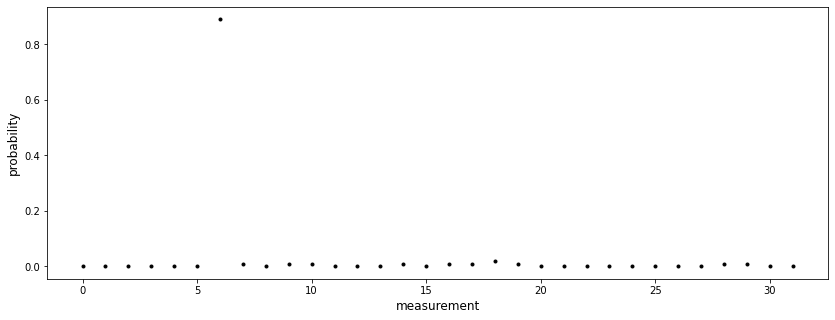


circuit diagram
0: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('0')───
              │               │               │               │               │               │
1: ───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───X───@───X───H───M('1')───
              │               │               │               │               │               │
2: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('2')───
              │               │               │               │               │               │
3: ───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───────@───H───X───────@───X───H───M('3')───
              │               │               │               │               │               │
4: ───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───X───Z───X───H───M('4')───


In [12]:
m = 6 # is the number that we hope to measure at the end of the circuit
k = 5 # is the number of qubits in the circuit
size = 3 # is the number of rotations in the circuit
times = 100 # is the number of circuit simulations

q = cirq.LineQubit.range( k )
oracle = oracle_gates( q, m )
diffuser = diffusion_gates( q )
grover = grover_circuit( q, oracle, diffuser, size )
result = simulate( q, grover, times )
display( grover, result, size, m )

grover circuit simulation

qubits        16
optimal size  200 rotations
actual  size  100 rotations
looking for   11111 among the numbers 0, 1, ..., 65535

measurements
[11111, 11634, 11111, 36101, 42743, 23724, 11111, 8733, 59577, 33917, 5605, 11111, 47744, 51543, 38906, 55912, 11111, 44840, 11111, 11111, 11111, 11111, 46518, 11111, 11111, 11111, 16376, 11111, 11111, 56703, 11111, 19191, 28703, 44116, 11111, 11111, 61674, 62107, 58913, 46791, 29845, 11111, 11111, 11111, 60187, 11111, 11111, 61517, 56403, 11111]


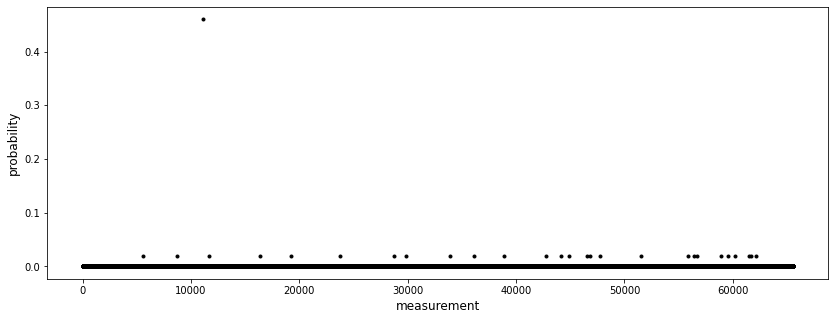

In [13]:
m = 11111
k = 16
size = 100
times = 50

q = cirq.LineQubit.range( k )
oracle = oracle_gates( q, m )
diffuser = diffusion_gates( q )
grover = grover_circuit( q, oracle, diffuser, size )
result = simulate( q, grover, times )
display( grover, result, size, m )